# Step 1: Bias assessment and correction
This notebook analysis the unconditional bias of total precipitation **for each calendar month**, comparing daily SEAS5 and ERA5 data.

Before an initial assessment of the skill of SEAS5 over the area of interest, both datasets (SEAS5 seasonal forecast as well as ERA5 quasi-observations) will need to be "harmonized". That is any systematic offsets or biases will need to be removed.

One could simply assess anomalies, but for the purpose of impact modelling and specific hydrological indicies such as SPI, absolute values are required. Therefore the assessment is performed on (bias corrected) daily data.

## ToDo
* **also assess lead time dependence**
* MVA Manzanas et al., “Bias Adjustment and Ensemble Recalibration Methods for Seasonal Forecasting.” looks promising... check what's implemented in climpred!
* Doblas-Reyes, Hagedorn, and Palmer, “The Rationale behind the Success of Multi-Model Ensembles in Seasonal Forecasting - II. Calibration and Combination.” --> they calibrate model **anomalies** using observed anomalies... not a preceding bias correction and then claibration...
* check multiplicative bias https://climpred.readthedocs.io/en/stable/metrics.html#multiplicative-bias
* [It’s safest to do anything like climatology removal before constructing climpred objects](https://climpred.readthedocs.io/en/stable/prediction-ensemble-object.html) -> In short, any sort of bias correcting or drift correction can also be done **prior** to instantiating a PredictionEnsemble object.
* do bias correction before actual skill computation
* https://climpred.readthedocs.io/en/stable/api/climpred.classes.HindcastEnsemble.remove_bias.html#climpred.classes.HindcastEnsemble.remove_bias
    * how to apply a simple bias correction to the precipitation dataset?
    * it wraps from XCLIM!
    * https://climpred.readthedocs.io/en/stable/bias_removal.html

In [1]:
from climpred import HindcastEnsemble
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

C:\Users\sb123\.conda\envs\Thesis2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## a) Read data

In [2]:
# read data from netCDFs and set-up a climpred HindcastEnsemble instance
hc = xr.open_dataarray(r"C:\Users\sb123\Documents\Massendaten\hindcast.nc")
obs = xr.open_dataarray(r"C:\Users\sb123\Documents\Massendaten\Observations_fin.nc")
hindcast = HindcastEnsemble(hc)
hindcast = hindcast.add_observations(obs)
hindcast

<climpred.HindcastEnsemble>
Initialized:
    tp       (init, member, latitude, longitude, lead) float32 ...
Uninitialized:
    None
Observations:
    tp       (time, latitude, longitude) float32 ...

In [52]:
# hindcast.get_initialized().tp.where(hindcast.get_initialized().tp.coords["valid_time.month"] == 1, drop=True)
# hindcast.get_initialized().tp.where(hindcast.get_initialized().tp.lead == 215, drop=True).coords["valid_time"].values
hindcast.get_initialized().coords["valid_time"].indexes["init"]

CFTimeIndex([1994-01-01 00:00:00, 1994-02-01 00:00:00, 1994-03-01 00:00:00,
             1994-04-01 00:00:00, 1994-05-01 00:00:00, 1994-06-01 00:00:00,
             1994-07-01 00:00:00, 1994-08-01 00:00:00, 1994-09-01 00:00:00,
             1994-10-01 00:00:00,
             ...
             2016-03-01 00:00:00, 2016-04-01 00:00:00, 2016-05-01 00:00:00,
             2016-06-01 00:00:00, 2016-07-01 00:00:00, 2016-08-01 00:00:00,
             2016-09-01 00:00:00, 2016-10-01 00:00:00, 2016-11-01 00:00:00,
             2016-12-01 00:00:00],
            dtype='object',
            length=276,
            calendar='proleptic_gregorian',
            freq='MS')

## b) Aggregate for each season
**NOT SURE HOW**
* **Objective**: Compare average *seasonal tp sums* for obs and init
* **Problem**, I would need to *resample* from a multidimensional coordinate "valid_time" which links the coordinates init and lead... but resampling is only supported for dimensions I think (Groupby works fine). Thereafter I would need to groupby season and then mean.

C:\Users\sb123\AppData\Local\Temp\ipykernel_23944\4065946304.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


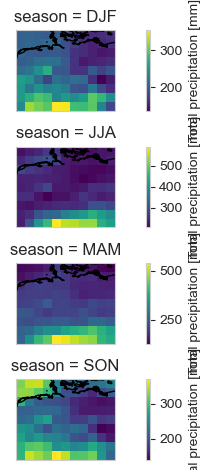

In [25]:
fig, ax = plt.subplots(nrows=4,subplot_kw={"projection":ccrs.PlateCarree()})
seasonal_obs = obs.resample(time="1QS").sum().groupby("time.season").mean()

for i in range(0,4):
    seasonal_obs.isel({"season":i}).plot(ax=ax.flat[i])
    ax.flat[i].add_feature(cfeature.COASTLINE)
    # a
    # ax.flat[i].borders
plt.tight_layout()
fig.show()

## c) Compute the bias

In [30]:
# trying to resample to seasonal frequency
hindcast.get_initialized().resample(valid_time = "1QS").sum()

KeyError: 'valid_time'

In [21]:
# this gives the error meaned over the members (e2o)
# TODO decide which alignment to use -> literature?
bias = hindcast.verify(metric="unconditional_bias", comparison="e2o", alignment="same_inits", dim=[])
print(bias)

fig, ax = plt.subplots()
bias.groupby("valid_time.month").mean().mean(dim=["latitude", "longitude"])["tp"].plot(ax=ax)
ax.set(ylabel="Average daily bias [mm]", xlabel="Month of year", title="Bias seasonal dependence")
ax.axhline(y=0, c='k')
fig.show()

INFO:root:initialized | lead: 1.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-02 00:00:00-2016-05-02 00:00:00
INFO:root:initialized | lead: 2.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-03 00:00:00-2016-05-03 00:00:00
INFO:root:initialized | lead: 3.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-04 00:00:00-2016-05-04 00:00:00
INFO:root:initialized | lead: 4.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-05 00:00:00-2016-05-05 00:00:00
INFO:root:initialized | lead: 5.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-06 00:00:00-2016-05-06 00:00:00
INFO:root:initialized | lead: 6.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-07 00:00:00-2016-05-07 00:00:00
INFO:root:initialized | lead: 7.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-08 00:00:00-2016-05-08 00:00:00
INFO:root:initialized | lead: 8.0 | inits: 1994-01-01 00:00:00-2016-0

[Text(0, 0.5, 'Valid time month'),
 Text(0.5, 0, 'Lead [days]'),
 Text(0.5, 1.0, 'Summertime dry bias')]

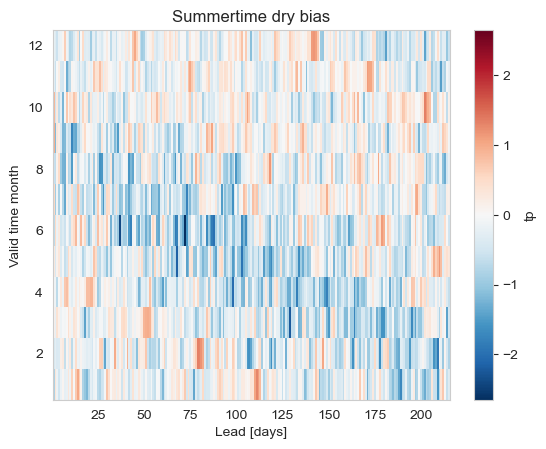

In [19]:
fig, ax = plt.subplots()
bias.groupby("init.month").mean().mean(dim=["latitude", "longitude"])["tp"].plot(ax=ax)
ax.set(ylabel="Valid time month", xlabel="Lead [days]", title="Summertime dry bias")